# Investigating Palworld Through Data Analysis
#### Team 11
- Ansh Aggarwal
- Sohum Balsara
- Bear Smith

In [1]:
# imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

## Introduction

In this project we study Palworld, a survival and monster-taming video game in which players collect characters called Pals to battle each other and help build their bases. Each Pal has a different set of skills and qualifications, a combination of such features as their element type, their HP in battle, and their "work suitability" for various tasks like farming or electricity production. We want to learn about how those factors combine and influence each other, and what relationships that may not be stated outwardly can be found between them. This may help players better understand their game and be more successful at it, or at least increase their knowledge of the logic behind Palworld.

Our primary research questions are:
- How are a Pal's work suitability scores correlated to its other statistics, such as its element type or battle skills?
- What relationship does Pal rarity have with their other statistics?

## Data 

### Data Source
- All data was taken from the [palworld.gg]("https://palworld.gg") database.
- We scraped each Pal's name, ID number, rarity, element(s), work suitability type(s) and level(s), HP, and defense scores.
- To make the data frame more easily filtered, the Pals' elements were listed using multiple boolean columns, each representing one element.
- For that same reason, their work suitabilities were also listed by column, but instead of True or False, each value was the Pal's level in that suitability or Nan if they did not have it. That way, dropna can be used to filter the data frame by element type.
- Finally, the Pals' HP and defense stats were converted to numbers in the data frame, so that mathematical operations can be done on those columns.

### Webscraping and cleaning functions overview
- `scrape_pal_ids()`
    - Creates a data frame with all the Pals' names as its index and one column of data containing their IDs.
- `scrape_pal_rarity()`
    - Adds a column containing the rarity of each Pal to the given data frame.
- `scrape_pal_elements()`
    - Adds the element or elements of each Pal to the given data frame using one-hot columns.
- `scrape_pal_work()`
    - Adds the work suitability or suitabilities of each Pal to the given data frame, along with its level.
- `scrape_pal_hp()`
    - Adds a column containing the HP of each Pal to the given data frame.
- `scrape_pal_defense()`
    - Adds a column containing the defense score of each Pal to the given data frame.

### Data overview
You can see a couple rows of our data below. We store the Pals' rarity, their element or elements, their work suitabilities with levels, and their HP and defense scores, all of which are measured and modeled against each other in our analysis. Our target feature is always one of them. The data set is not perfect: For the purposes of analysis, it could stand to be larger, as 225 Pals is relatively few when they are split up among various permutations of 9 elements and 12 work suitabilities. However, that's out of our control. We could have scraped more of the Pals' battle statistics, since some interesting analysis could probably be done on that, but none of our present ideas required them.

## Webscraping and cleaning

In [2]:
# list all the functions you have for webscraping and cleaning. Make sure write full 
# docstrings for each function

def scrape_pal_ids(url = "https://palworld.gg/pals"):
    """
    Scrape Pal IDs from the given URL.

    Args:
        url (str): The URL of the Palworld database page, assumed to be the current link unless otherwise specified.

    Returns:
        DataFrame: A dataFrame of Pal names and IDs.
    """
    response = requests.get(url).text
    soup = BeautifulSoup(response)

    # Find all Pal ID elements
    pal_dict = {}
    for pal in soup.find_all("div", class_ = "pal"):

        # Remove empty Pal entries.
        if pal.attrs["style"] == "display:none;":
            continue

        # Get the ID and name of the Pal and add them to the dictionary.
        pal_id_element = pal.find('span', class_='index').text.strip()
        pal_dict[pal.find("div", class_ = "name").next_element.strip()] = pal_id_element

    # Convert the dictionary to a DataFrame before returning it.
    return pd.DataFrame().from_dict(pal_dict, orient = "index", columns = ["ID"])

In [3]:
def scrape_pal_rarity(pal_df, url = "https://palworld.gg/pals"):
    """
    Scrape the rarity of each Pal listed in the database.

    Args:
        url (str): The URL of the database page, assumed to be the current link unless otherwise specified.
        pal_df (DataFrame): The DataFrame of Pal data to update.

    Returns:
        pal_df (DataFrame): The DataFrame given, with the rarity of each Pal added under a new column.
    """
    soup = BeautifulSoup(requests.get(url).text)

    # Find all Pals, then find each of their rarities.
    pal_tag = soup.find_all("div", class_ = "pal")
    for pal in pal_tag:

        # Remove empty Pal entries.
        if pal.attrs["style"] == "display:none;":
            continue

        # The "name" class is used twice in each Pal entry, first for their name, then for their rarity.
        name_class = pal.find_all("div", class_ = "name")
        # (Using next_element here rather than .text to avoid also getting the text from the nested children.)
        # Add the rarity of the Pal to the DataFrame under its name.
        pal_df.loc[name_class[0].next_element.strip(), "Rarity"] = name_class[1].next_element

    return pal_df


In [4]:
def scrape_pal_elements(pal_df, url = "https://palworld.gg/pals"):
    """
    Scrape the element or elements of each Pal listed in the database.

    Args:
        url (str): The URL of the database page, assumed to be the current link unless otherwise specified.
        pal_df (DataFrame): The DataFrame of Pal data to update.

    Returns:
        pal_df (DataFrame): The DataFrame given, with a dummy variable added for each element,
        True meaning that a Pal does belong to them and False for not.
    """
    soup = BeautifulSoup(requests.get(url).text)

    # Find each Pal entry.
    pal_tag = soup.find_all("div", class_ = "pal")
    for pal in pal_tag:
        # Remove empty Pal entries.
        if pal.attrs["style"] == "display:none;":
            continue

        # Load the individual entry page for the Pal.
        pal_page = requests.get("https://palworld.gg" + pal.a.attrs["href"]).text
        pal_soup = BeautifulSoup(pal_page)

        # Scrape the Pal's name.
        pal_name = pal_soup.find("h1", class_ = "name").text.strip()

        # Initialize all the element column values for this Pal to False, as none have been found yet.
        pal_df.loc[pal_name, ["Earth", "Fire", "Dragon", "Dark", "Electricity", "Water", "Ice", "Leaf", "Normal"]] = False

        # Scrape the elements of the Pal.
        pal_elems_tags = pal_soup.find("div", class_ = "elements").find_all("div", class_ = "name")
        for tag in pal_elems_tags:
            # For each found element, change the Pal's value in the corresponding column to True.
            pal_df.loc[pal_name, tag.text] = True
        
    return pal_df


In [5]:
def scrape_pal_work(pal_df, url = "https://palworld.gg/pals"):
    """
    Scrape the work suitabilities of each Pal listed in the database, including the level of each work type.

    Args:
        url (str): The URL of the database page, assumed to be the current link unless otherwise specified.
        pal_df (DataFrame): The DataFrame of Pal data to update.

    Returns:
        pal_df (DataFrame): The DataFrame given, with 13 new columns added: 12 representing the work suitabilities
        of Pals, each filled with NaN or the Pal's skill level for that task, and one column counting the number of suitabilities
        the Pal has in total.
    """
    soup = BeautifulSoup(requests.get(url).text)

    # Find each Pal entry.
    pal_tag = soup.find_all("div", class_ = "pal")
    for pal in pal_tag:
        # Remove empty Pal entries.
        if pal.attrs["style"] == "display:none;":
            continue

        # Load the individual entry page for the Pal.
        pal_page = requests.get("https://palworld.gg" + pal.a.attrs["href"]).text
        pal_soup = BeautifulSoup(pal_page)

        # Scrape the name of the Pal.
        pal_name = pal_soup.find("h1", class_ = "name").text.strip()

        # Scrape the suitabilities of the Pal, and for each one that is found add its level to the column with the suitability's name.
        pal_work_tags = pal_soup.find("div", class_ = "works").find_all("div", class_ = "active item")
        for tag in pal_work_tags:
            pal_df.loc[pal_name, tag.find("div", class_ = "name").text] = int(tag.find("span", class_ = "value").text)
        # Add the pal's total number of suitabilities as a new column.
        pal_df.loc[pal_name, "Number of work suitabilities"] = len(pal_work_tags)
        
    return pal_df


In [6]:
def scrape_pal_hp(pal_df, url = "https://palworld.gg/pals"):
    """
    Scrape the HP of each Pal listed in the database.

    Args:
        url (str): The URL of the database page, assumed to be the current link unless otherwise specified.
        pal_df (DataFrame): The DataFrame of Pal data to update.

    Returns:
        pal_df (DataFrame): The DataFrame given, with a new column representing the Pals' HPs.
    """
    soup = BeautifulSoup(requests.get(url).text)

    # Find each Pal entry.
    pal_tag = soup.find_all("div", class_ = "pal")
    for pal in pal_tag:
        # Remove empty Pal entries.
        if pal.attrs["style"] == "display:none;":
            continue

        # Load the individual entry page for the Pal.
        pal_page = requests.get("https://palworld.gg" + pal.a.attrs["href"]).text
        pal_soup = BeautifulSoup(pal_page)

        # Scrape the name of the Pal.
        pal_name = pal_soup.find("h1", class_ = "name").text.strip()

        # Scrape the HP of the pal (the first entry in the stats section) and add it to the HP column.
        pal_hp = int(pal_soup.find("div", class_ = "stats").find_all("div", class_ = "value")[0].text)
        pal_df.loc[pal_name, "HP"] = pal_hp
        
    return pal_df


In [7]:
def scrape_pal_defense(pal_df, url = "https://palworld.gg/pals"):
    """
    Scrape the defense score of each Pal listed in the database.

    Args:
        url (str): The URL of the database page, assumed to be the current link unless otherwise specified.
        pal_df (DataFrame): The DataFrame of Pal data to update.

    Returns:
        pal_df (DataFrame): The DataFrame given, with a new column representing the Pals' defense scores.
    """
    soup = BeautifulSoup(requests.get(url).text)

    # Find each Pal entry.
    pal_tag = soup.find_all("div", class_ = "pal")
    for pal in pal_tag:
        # Remove empty Pal entries.
        if pal.attrs["style"] == "display:none;":
            continue

        # Load the individual entry page for the Pal.
        pal_page = requests.get("https://palworld.gg" + pal.a.attrs["href"]).text
        pal_soup = BeautifulSoup(pal_page)

        # Scrape the name of the Pal.
        pal_name = pal_soup.find("h1", class_ = "name").text.strip()

        # Scrape the defense of the pal (the second entry in the stats section) and add it to the defense column.
        pal_hp = int(pal_soup.find("div", class_ = "stats").find_all("div", class_ = "value")[1].text)
        pal_df.loc[pal_name, "Defense"] = pal_hp
        
    return pal_df


In [8]:
pal_df = scrape_pal_defense(scrape_pal_hp(scrape_pal_work(scrape_pal_elements(scrape_pal_rarity(scrape_pal_ids())))))
pal_df

,ID,Rarity,Earth,Fire,Dragon,Dark,Electricity,Water,Ice,Leaf,...,Kindling,Gathering,Generating Electricity,Watering,Cooling,Farming,Medicine Production,Planting,HP,Defense
Anubis,#100,Epic,True,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,100.0
Arsox,#42,Common,False,True,False,False,False,False,False,False,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,95.0
Astegon,#98,Epic,False,False,True,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,125.0
Azurmane,#136,Rare,False,False,False,False,True,False,False,False,...,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,130.0,110.0
Azurobe,#82,Rare,False,False,True,False,False,True,False,False,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,110.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wumpo Botan,#91,Epic,False,False,False,False,False,False,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,140.0,110.0
Xenogard,#126,Epic,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0,130.0
Xenolord,#127,Epic,False,False,True,True,False,False,False,False,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,130.0,120.0
Xenovader,#125,Rare,False,False,False,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0


## Visualizations

### Visualization functions overview
List all the functions you have written for visualization. For each one, write one sentence to describe it. 
- `build_work_features()`
    - Add new columns to the dataframe containing each Pal's highest work suitability level, a list of all its suitabilities, and its total number of suitabilities.
- `group_work_by_element()`
    - Make a data frame representing each of the elements' average scores in each work suitability.


In [9]:
def build_work_features(df, work_list):
    """ Creates a data frame based on the given frame of Pal data with three new features added: 
    Each Pal's highest work suitability level, a list of all its suitabilities, and its total number of suitabilities.

    Args:
        df (DataFrame): The data frame to draw Pal data from and base the return frame off of.
        work_list (list(str)): The titles of the columns containing Pal work data in the given frame.

    Returns:
        out (DataFrame): A copy of the given data frame with the three new columns added to it.
    """
    
    # Initialize the return data frame as a copy of the given one.
    out = df.copy()

    # Grab the subset of the data frame representing the work columns.
    work_cols = df[work_list]

    # For every row of the data frame:
    for idx in range(len(work_cols)):
        # Declare a series variable for the work stats of the Pal at this row and drop all NaN values, 
        # which would be the work suitabilities it doesn't have.
        pal = work_cols.iloc[idx, :]
        pal = pal.dropna()

        # Get the Pal's highest work suitability level by sorting the series and place it into the data frame.
        out.loc[pal.name, "Highest Work Suitability Level"] = pal.sort_values(ascending = False).iloc[0]

        # Get a string of the Pal's work types by joining all of its non-NaN work labels and place it into the data frame.
        out.loc[pal.name, "Work Types"] = ", ".join(pal.index)

        # Get the number of work types the Pal has as the length of the index and place it into the data frame.
        out.loc[pal.name, "Work Skill Count"] = len(pal.index)

    return out


def group_work_by_element(df, work_list):
    """ Makes a data frame representing the Pals' average scores in each work suitability by element.
    (Note that many Pals have multiple elements and thus have to be counted for each of them.)

    Args:
        df (DataFrame): The data frame to draw Pal data from and base the return frame off of.
        work_list (list(str)): The titles of the columns containing Pal work data in the given frame.
    
    Returns:
        work_elem_stats (DataFrame): A data frame with elements for its index and work suitabilities for its columns,
        populated in each cell with the average score of all the Pals in that element at that work skill.
    """

    # Declare a list of the elements.
    element_list = ["Earth", "Fire", "Dragon", "Dark", "Electricity", "Water", "Ice", "Leaf", "Normal"]

    # Initialize an empty data frame to hold the return values.
    work_elem_stats = pd.DataFrame(index = element_list, columns = work_list, dtype = float)
    
    # For every element:
    for elem in element_list:
        # Get all the pals who have that element == True.
        current_pals = df.loc[df[elem], :]

        # For all the work suitabilities:
        for work in work_list:
            # Take the mean of all the current Pals' stats in that job, filling NaNs with 0, and place it into the data frame.
            work_elem_stats.loc[elem, work] = current_pals[work].fillna(value = 0, inplace = False).mean()
    
    return work_elem_stats


# Declare the names of work-type columns
work_list = ['Handiwork', 'Mining',
       'Transporting', 'Deforesting',
       'Kindling', 'Gathering', 'Generating Electricity', 'Watering',
       'Cooling', 'Farming', 'Medicine Production', 'Planting']

# Define fixed colors for each element
element_colors = {
    "Earth": "#8B4513",
    "Fire": "#FF4500",
    "Dragon": "#800080",
    "Dark": "#2F4F4F",
    "Electricity": "#FFD700",
    "Water": "#1E90FF",
    "Ice": "#00CED1",
    "Leaf": "#228B22", 
    "Normal": "#A9A9A9"
}


### Visualization 1

In [10]:
# 1. Scatter plot

# Prepare the data frame for visualizations
pal_frame_vis = build_work_features(pal_df, work_list)

fig1 = px.scatter(
    pal_frame_vis.sort_values(by = "Highest Work Suitability Level", ascending = True),
    x="Highest Work Suitability Level",
    y="HP",
    opacity = 0.3,
    hover_data={"ID":True, "Rarity":True, "Work Types":True},
    title="Work Suitability vs HP"
)
fig1.show()

#### Visualization 1 discussion
We made this scatterplot in order to determine if there is a correlation between a Pal's strength at work, determined as the highest level it has achieved in any of its skills, and its hit points in battle. We did find a positive correlation, suggesting that Pals are generally "powerful" across all their metrics or none of them.

### Visualization 2

In [11]:
# 2. Grouped Bar Chart
work_elem_stats = group_work_by_element(pal_frame_vis, work_list)

fig2 = px.bar(
    work_elem_stats,
    barmode="group",
    title="Average Work Suitability Level by Element Type & Work Type",
    labels = {"value" : "Average skill level", "index" : "Element Type", "variable" : "Work skill" }
)
fig2.show()

#### Visualization 2 discussion
We made this graph to determine if a Pal's element type influenced its work suitabilities in a way that lined up with real-world associations, such as how you'd expect fire types to be good at kindling. The results were entirely in line with our predictions, as you can see that water types are good at watering, leaf types at planting, ice types at cooling, etc. This shows that an individual Pal's work suitabilities, and particularly its levels in them, are likely to be based in part on its elements.

### Visualization 3

In [12]:
# 3. Heatmap
heat_df = pal_frame_vis.groupby(["Rarity","Work Skill Count"]).size().reset_index(name="Count")
fig3 = px.density_heatmap(
    heat_df,
    x="Work Skill Count", y="Rarity", z="Count", color_continuous_scale="Viridis",
    title="Rarity vs. Number of Work Suitabilities (Frequency)"
)
fig3.show()

#### Visualization 3 discussion
We made this graph to determine if rarer Pals are likely to have more work skills than more common Pals. We found that they do not, as all rarities of Pal are most likely to have 2-3 work skills. There are only two Pals that have 6-7 work skills at all, and they are a Common and a Rare. 

## Models

### Modeling functions overview
- `fit_linear()`
    - Fit a linear model to the data and output the r2, slope and intercept
- `fit_dec_tree()`
    - Fit a decision tree to a given data frame and some x and y features, and output a confusion matrix of the cross-validated model and the tree plot and accuracy score of the whole-dataset model. 
    - Note that sensitivity and specificity cannot be calculated because the data is categorical, not binary.

In [13]:
def fit_linear(df, y_feat, x_feat):
    """
    Fit a linear model to the data and output the r2, slope and intercept.
   Args:
        df (DataFrame): The DataFrame of Pal data to use.
        y_feat (str): The name of the feature to use as the dependent variable.
        x_feat (str): The name of the feature to use as the independent variable.
    Returns:
        r2 (float): The r-squared value of the fitted model.
        slope (float): The slope of the fitted model.
        intercept (float): The intercept of the fitted model.
    """
    
    # Drop rows with NaN values in the specified columns.
    clean_df = df[[y_feat, x_feat]].dropna()
    X = clean_df[[x_feat]].to_numpy().reshape(-1, 1)
    y = clean_df[y_feat].to_numpy()
    # Split the data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Fit the linear regression model.
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Make predictions on the test set.
    y_pred = model.predict(X_test)
    # Calculate the r-squared value, slope, and intercept.
    r2 = r2_score(y_test, y_pred)
    slope = model.coef_[0]
    intercept = model.intercept_
    return r2, slope, intercept



def fit_dec_tree(df, x_feats, y_feat):
    """ Fit a decision tree with the given x and y features of the given data frame. 
    Plot it, cross-validate it, and plot a confusion matrix, then return its accuracy.
    Note: We cannot compute its sensitivity or specificity because the feature being predicted may be categorical or continuous, not binary.
    (In our actual use of the function on the Palworld data, it is categorical.)

    Args:
        df (DataFrame): The dataframe to get the features from.
        x_feats (list): A list of column names to select from the data frame.
        y_feat (strs): The name of the y feature to select from the data frame.

    Returns:
        acc (float): The accuracy of the decision tree model.
    """

    # Declare the x and y features using the given feature names and data frame.
    x = np.array(df[x_feats]).reshape(-1, len(x_feats))
    y = np.array(df[y_feat])

    # Initialize an 8-fold stratified K-fold for the data, as well as a decision tree classifier.
    # We're using 8 because the Pal dataset does not have enough samples to use 10 (it produced a warning message).
    skfold = StratifiedKFold(n_splits = 8)
    pal_dec_tree = tree.DecisionTreeClassifier(max_depth = 3)

    # Declare an empty array to hold the predicted values.
    y_pred = np.empty_like(y)

    # For each split:
    for train_idx, test_idx in skfold.split(x, y):
        # Make the current testing and training folds from the data.
        x_train = x[train_idx, :]
        y_train = y[train_idx]
        x_test = x[test_idx, :]

        # Fit the tree on the current training fols.
        pal_dec_tree.fit(x_train, y_train)

        # Make predictions on the current test fold and add it to the array in the according place.
        y_pred[test_idx] = pal_dec_tree.predict(x_test)

    # Create a confusion matrix with the predicted values.
    conf_mat = confusion_matrix(y_true = y, y_pred = y_pred)
    conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels = np.unique(y))
    conf_mat_disp.plot()
    plt.suptitle(f"Confusion matrix for decision tree using {", ".join(x_feats)} to predict {y_feat}")
    plt.grid(False)

    # Fit the tree on the whole dataset and plot it.
    pal_dec_tree.fit(x, y)
    plt.figure()
    plt.gcf().set_size_inches(18, 8)
    tree.plot_tree(pal_dec_tree, feature_names = x_feats, class_names = pal_dec_tree.classes_)
    plt.suptitle(f"Decision tree using {", ".join(x_feats)} to predict {y_feat}")
    

    # Calculate the accuracy of the model.
    acc = accuracy_score(y, y_pred)

    return acc


def fit_random_forest(df, x_feats, y_feat):
    """ Fit a random forest classifier with the given x and y features of the given data frame. 
    Cross-validate it, plot a confusion matrix, and plot the importance of the features, then return its accuracy.
    Note: We cannot compute its sensitivity or specificity because the feature being predicted may be categorical or continuous, not binary.
    (In our actual use of the function on the Palworld data, it is categorical.)

    Args:
        df (DataFrame): The dataframe to get the features from.
        x_feats (list): A list of column names to select from the data frame.
        y_feat (strs): The name of the y feature to select from the data frame.

    Returns:
        acc (float): The accuracy of the random forest classifier.
    """

    # Declare the x and y features using the given feature names and data frame.
    x = np.array(df[x_feats]).reshape(-1, len(x_feats))
    y = np.array(df[y_feat])

    # Initialize an 8-fold stratified K-fold for the data, as well as a random forest classifier.
    # We're using 8 because the Pal dataset does not have enough samples to use 10 (it produced a warning message).
    skfold = StratifiedKFold(n_splits = 8)
    pal_ran_for = RandomForestClassifier(max_depth = 5)

    # Declare an empty array to hold the predicted values.
    y_pred = np.empty_like(y)

    # For each split:
    for train_idx, test_idx in skfold.split(x, y):
        # Make the current testing and training folds from the data.
        x_train = x[train_idx, :]
        y_train = y[train_idx]
        x_test = x[test_idx, :]

        # Fit the forest on the current training fols.
        pal_ran_for.fit(x_train, y_train)

        # Make predictions on the current test fold and add it to the array in the according place.
        y_pred[test_idx] = pal_ran_for.predict(x_test)

    # Create a confusion matrix with the predicted values.
    conf_mat = confusion_matrix(y_true = y, y_pred = y_pred)
    conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels = np.unique(y))
    conf_mat_disp.plot()
    plt.suptitle(f"Confusion matrix for random forest predicting {y_feat}")
    plt.grid(False)

    # Declare a series of the importance of each feature in the forest model, and sort it.
    feats = pd.Series(data = pal_ran_for.feature_importances_, index = x_feats)
    feats.sort_values(ascending = True, inplace = True)
    
    # Plot the ranked importance of all features in the model.
    plt.figure()
    plt.barh(feats.index, feats.values)
    plt.gcf().set_size_inches(5, 10)
    plt.xlabel("Feature importance, or mean decrease in Gini across all decision trees")
    plt.suptitle(f"Importance of all features in determining {y_feat} using random forest classifier")

    # Calculate the accuracy of the model.
    acc = accuracy_score(y, y_pred)

    return acc

### Model 1

#### Model 1 discussion
We wanted to see if Pals that are better workers also fare better in battle. So, we plotted each Pal's highest work suitability score (out of all of its personal suitabilities) against HP in a scatterplot that you see in the above data visualizations. This lets us see if the Pals that are most specialized to a task are also "high-value" in combat. Then, noticing a positive correlation in the variables' relationship, we thought that a linear regression model would fit it. No preprocessing had to be done before the modeling.

In [14]:
r2, slope, intercept = fit_linear(pal_frame_vis, "HP", "Highest Work Suitability Level")
print(f"Model 1: R2 = {r2}, Slope = {slope}, Intercept = {intercept}")

Model 1: R2 = 0.3991006793555303, Slope = 12.481549523296692, Intercept = 66.27680466250673


In [15]:
# Replot the scatter plot with the fitted line
fig1 = px.scatter(
    pal_frame_vis.sort_values(by = "Highest Work Suitability Level", ascending = True),
    x="Highest Work Suitability Level",
    y="HP",
    opacity = 0.3,
    hover_data={"ID":True, "Rarity":True, "Work Types":True},
    title="Work Suitability vs HP"
)

fig1.add_scatter(
    x=pal_frame_vis["Highest Work Suitability Level"],
    y=intercept + slope * pal_frame_vis["Highest Work Suitability Level"],
    mode="lines",
    name="Fitted Line",
    line=dict(color="red", width=2)
)
fig1.show()

#### Model 1 interpretation

The fitted line shows a positive correlation between highest work suitability level and HP, indicating that Pals with a greater highest work suitability levels tend to also have higher HP. The slope of the line suggests that for each increase by 1 level of a Pal's best work skill, their HP increases by approximately 12 points.  The R2 value indicates how well the model explains the variance in HP based on work suitability level. Ours is low, being only about 0.4, or 40%. This is because there is a high variance in HP across all work levels, so although the correlation exists, it is not particularly strong.

### Model 2

#### Model 2 discussion
We wanted to see if HP and Defense can predict a Pal's rarity, to see if rarer Pals are generally more capable in battle. We chose to use a decision tree classifier. This lets us not only attempt to classify the Pals, but also creates a clean visual output of a tree plot. No preprocessing had to be done to the data beforehand.

0.6622222222222223


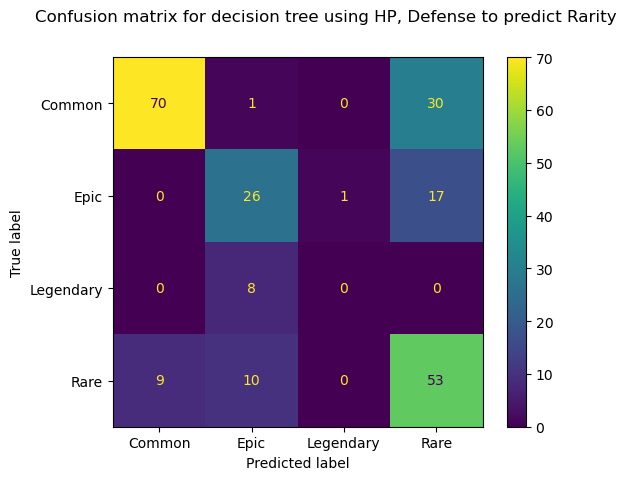

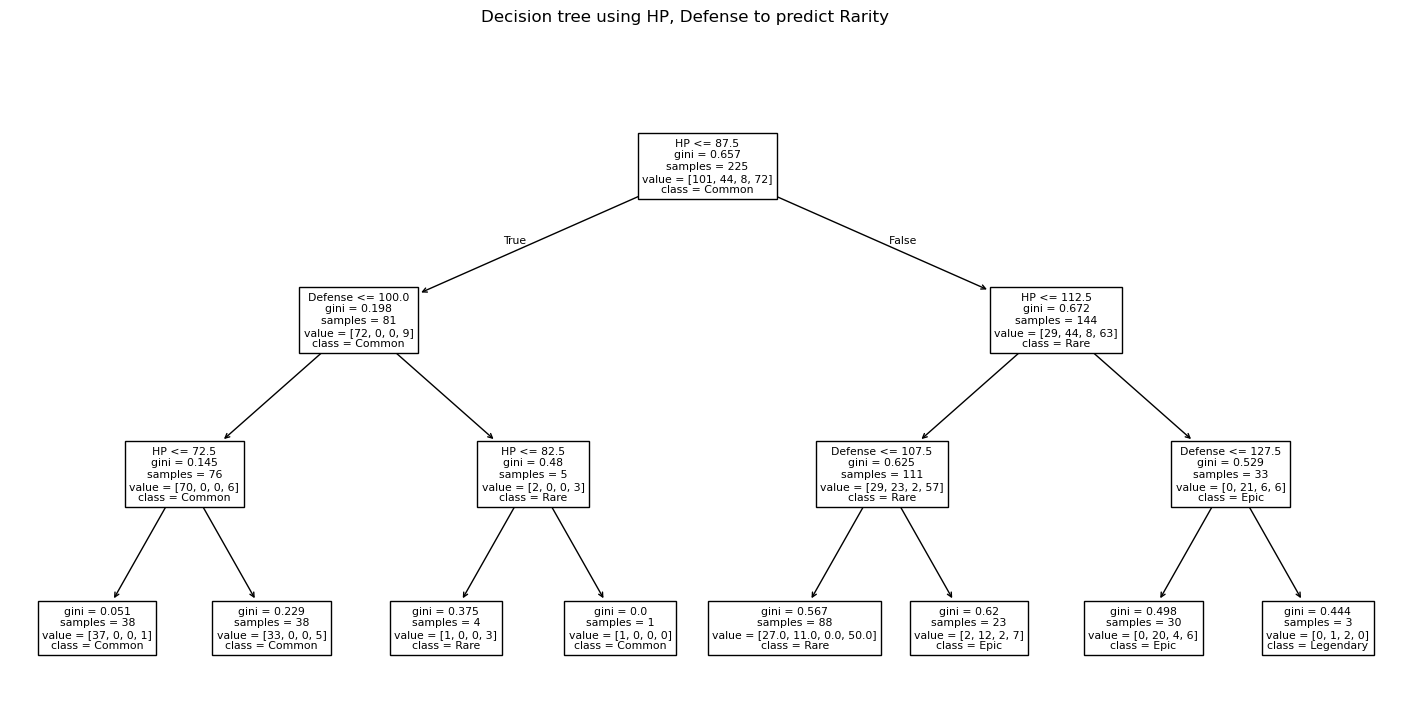

In [16]:
print(fit_dec_tree(pal_df, ["HP", "Defense"], "Rarity"))

#### Model 2 interpretation
The decision tree has an accuracy score of 66%, which is again only somewhat significant. This suggests that HP and defense alone are not correlated enough with rarity to accurately predict it. As the confusion matrix shows, the model tends to overpredict Rare and Epic pals, and out of the scarce 8 Legendary Pals, all of them were mispredicted. This likely means that the benefits offered by owning rarer Pals lies in their other statistics, potentially such as work capability.

### Model 3

#### Model 3 discussion
Considering that the other two models were shots in the dark based on what we guessed would be related values, we wanted to find out which of our scraped features were actually the best predictor of rarity. So, we decided to throw the entire data set into a random forest classifier so that we can see the feature importance in its output.

0.6444444444444445


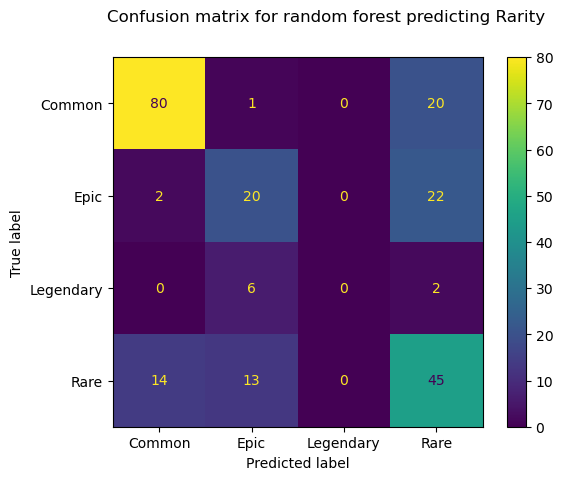

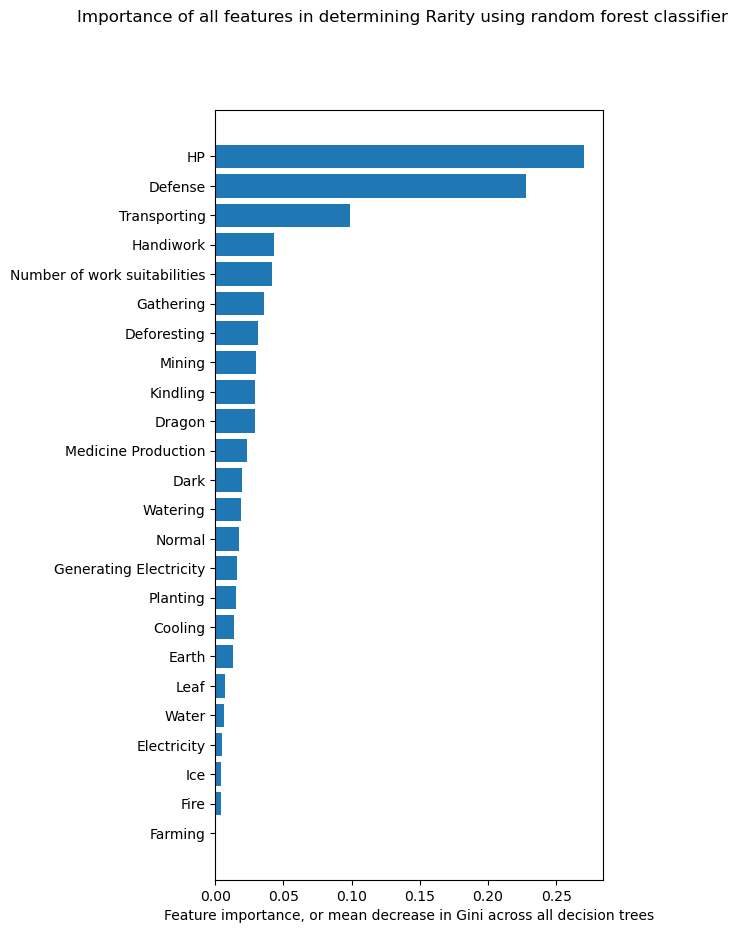

In [17]:
x_feats = pal_df.columns[1:].drop("Rarity")
print(fit_random_forest(pal_df, x_feats, "Rarity"))

#### Model 3 interpretation
This model performed roughly the same as or worse than the single decision tree. It has the same misprediction tendencies as the tree, and its accuracy score hovers in the range of 60-65%, although this model is somewhat unstable and the score changes slightly every time the code is rerun. From the feature importance graph, we can see that HP and defense are actually the two most important predictors of rarity, meaning that our previous intuition was correct. There may still be other features more important than those two, but out of the ones we scraped, HP and defense are the most relevant.

## Discussion

### Results and further work
To conclude our research questions, we learned that the rarity of Pals is correlated more with their HP and defense statistics than with any of the other features we studied. Additionally, their work suitabilies are determined in large part by their element types, and the breadth of their suitabilities is largely unrelated to their rarity. None of the relationships we found between features were textbook-perfect, though, as is often the case for real-life data. In the future, it could be useful to scrape the rest of the Pals' battle statistics and analyze those with regards to rarity, in order to truly determine if HP is the best predictor of Pal rarity. Or, since our work generally focused on studying individual Pals and finding trends in their statistics, one could start trying to analyze the Pals in teams: For example, how can one build the team with the most diverse skillset and most power for the "cheapest" rarity.

### Contributions
- Sohum came up with the majority of our research questions and visualization ideas.
- Bear wrote the web scraping functions.
- Ansh and Bear wrote the data visualizations.
- Sohum wrote the linear regression, and Bear wrote the decision tree and random forest.
- Bear filled out the template.
- Ansh put together the slideshow.